In [1]:
print(r"""
Run


$ python add_paraphrase.py data/spider-20190205/dev.json data/spider-20190205/dev_augmented.json 20

$ python preprocess.py --config configs/spider-20190205/arxiv-1906.11790v1_augmented.jsonnet

$ python infer.py --config configs/spider-20190205/arxiv-1906.11790v1_augmented.jsonnet \
    --logdir logdirs/20190428-stability/bs=50,lr=1.0e-03,end_lr=0e0,att=2/bs=50,lr=1.0e-03,end_lr=0e0,att=2 \
    --step 40000 --section val --beam-size 100 --output ~/result/inferred_augmented --nproc 64

$ python eval.py --config configs/spider-20190205/arxiv-1906.11790v1_augmented.jsonnet \
    --inferred ~/result/inferred_augmented --output ~/result/eval_augmented --section val --evaluate_beams_individually


For reranking


python infer.py --config configs/spider-20190205/arxiv-1906.11790v1.jsonnet \
    --logdir logdirs/20190428-stability/bs=50,lr=1.0e-03,end_lr=0e0,att=2/bs=50,lr=1.0e-03,end_lr=0e0,att=2 \
    --step 40000 --section train --beam-size 100 --output ~/results/train_results.jsonl --nproc 64
python eval.py --config configs/spider-20190205/arxiv-1906.11790v1.jsonnet \
    --inferred ~/results/train_results.jsonl --output ~/results/train_scores.json --section train \
    --evaluate_beams_individually
python generate_matching_data.py ~/results/train_scores.json ~/results/matching_data.pkl
python scripts/train_match_model.py ~/results/matching_data.pkl \
    ~/results/matching-model-checkpoints-try-2 ~/results/matching-model-stats.pkl
    python process_data.py
""")


Run


$ python add_paraphrase.py data/spider-20190205/dev.json data/spider-20190205/dev_augmented.json 20

$ python preprocess.py --config configs/spider-20190205/arxiv-1906.11790v1_augmented.jsonnet

$ python infer.py --config configs/spider-20190205/arxiv-1906.11790v1_augmented.jsonnet \
    --logdir logdirs/20190428-stability/bs=50,lr=1.0e-03,end_lr=0e0,att=2/bs=50,lr=1.0e-03,end_lr=0e0,att=2 \
    --step 40000 --section val --beam-size 100 --output ~/result/inferred_augmented --nproc 64

$ python eval.py --config configs/spider-20190205/arxiv-1906.11790v1_augmented.jsonnet \
    --inferred ~/result/inferred_augmented --output ~/result/eval_augmented --section val --evaluate_beams_individually


For reranking


python infer.py --config configs/spider-20190205/arxiv-1906.11790v1.jsonnet \
    --logdir logdirs/20190428-stability/bs=50,lr=1.0e-03,end_lr=0e0,att=2/bs=50,lr=1.0e-03,end_lr=0e0,att=2 \
    --step 40000 --section train --beam-size 100 --output ~/results/train_results.jsonl

In [2]:
import re

In [32]:
import json
from os.path import expanduser
import os
os.environ["CUDA_VISIBLE_DEVICES"] = ""
from collections import defaultdict, namedtuple
from itertools import count

import numpy as np
import matplotlib.pyplot as plt

from seq2struct.models.match_model import MatchModel
from tqdm import tqdm_notebook as tqdm
import pickle

In [5]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [33]:
with open(expanduser("~/results/matching-model-stats.pkl"), "rb") as f:
    s = pickle.load(f)

In [34]:
s

{'auc': 0.9506275,
 'eval_accuracy': 0.951143,
 'f1_score': 0.9271833,
 'false_negatives': 202.0,
 'false_positives': 390.0,
 'loss': 0.13431974,
 'precision': 0.90622747,
 'recall': 0.9491312,
 'true_negatives': 7756.0,
 'true_positives': 3769.0,
 'global_step': 10222}

In [36]:
(s['true_positives'] + s['true_negatives']) / (s['true_positives'] + s['true_negatives'] + s['false_positives'] + s['false_negatives'])

0.951143

In [37]:
with open(expanduser("~/results/full-data.pkl"), "rb") as f:
    by_sql_humanwording_and_compwording = pickle.load(f)

In [45]:
beam = by_sql_humanwording_and_compwording['SELECT count(*) FROM singer']['How many singers do we have?']['How many singers do we have?']

In [67]:
def logit_match(beam):
    no_match, match = beam['match_score']['probabilities']
    return match - no_match

In [17]:
def shufd(xs, rng):
    xs = list(xs)
    rng.shuffle(xs)
    return xs

In [18]:
def round_robin(item_sequences, resequencer):
    """
    Returns a sequence where every element in the sequence is in order
    of it's position in the original item sequences, but is otherwise
    in random order.
    """
    result = []
    for idx in count():
        done = True
        for sequence in resequencer(item_sequences):
            if idx >= len(sequence):
                continue
            done = False
            result.append(sequence[idx])
        if done:
            break
    return result

In [33]:
def sorted_by_score(beams):
    return sorted(beams, key=lambda x: x['score'], reverse=True)

In [68]:
def individual_human(by_human_wording):
    # only goes through the beams for an indivdual human wording
    for human_wording in by_human_wording:
        yield by_human_wording[human_wording][human_wording]

def individual_human_bert_approved(by_human_wording):
    # only goes through the beams for an indivdual human wording,
    # first traversing the bert-approved beams
    for human_wording in by_human_wording:
        beam = by_human_wording[human_wording][human_wording]
        yield [b for b in beam if b['match_score']['labels']] + [b for b in beam if not b['match_score']['labels']]

def individual_human_bert_ordered(by_human_wording):
    # only goes through the beams for an indivdual human wording,
    # first traversing the bert-approved beams
    for human_wording in by_human_wording:
        beam = by_human_wording[human_wording][human_wording]
        yield sorted(beam, key=logit_match, reverse=True)
#         yield [b for b in beam if b['match_score']['labels']] + [b for b in beam if not b['match_score']['labels']]


def individual_human_with_computer_paraphrasing(by_human_wording, k):
    # round-robins the beams for k randomly selected computer paraphrases
    # of the human sentence
    for human_wording in by_human_wording:
        for_wording = by_human_wording[human_wording]
        selected_wordings = list(np.random.choice(list(for_wording), size=min(k, len(for_wording)), replace=False))
        selected_wordings = [human_wording] + selected_wordings
        yield round_robin([for_wording[w] for w in selected_wordings], lambda x : x[:1] + shufd(x[1:], np.random))

def individual_human_with_computer_paraphrasing_by_score(by_human_wording, k):
    # round-robins the beams for k randomly selected computer paraphrases
    # of the human sentence
    for human_wording in by_human_wording:
        for_wording = by_human_wording[human_wording]
        selected_wordings = list(np.random.choice(list(for_wording), size=min(k, len(for_wording)), replace=False))
        selected_wordings = [human_wording] + selected_wordings
        yield sorted_by_score([b for w in selected_wordings for b in for_wording[w]])

def all_human(by_human_wording):
    yield round_robin(list(individual_human(by_human_wording)), lambda x: shufd(x, np.random))

In [60]:
def beam_count(item):
    """
    Takes several sequential results and returns the number
    of beams that must be viewed to produce an exact match,
    or infinity if it is impossible.
    """
    beams = set()
    for beam in item:
        beams.add(beam['predicted'])
        if beam['exact']:
            return len(beams)
    return float('inf')
def probs(counts, max_count):
    by = []
    for count in range(1, max_count + 1):
        by.append(np.mean([x <= count for x in counts]) * 100)
    return by

In [61]:
def all_beam_counts(strategy, by_sql_hw_cw):
    for for_wording in by_sql_hw_cw.values():
        for beams in strategy(for_wording):
            yield beam_count(beams)

def probs_for_strat(strategy, by_sql_hw_cw, max_count):
    return probs(list(all_beam_counts(strategy, by_sql_hw_cw)), max_count)

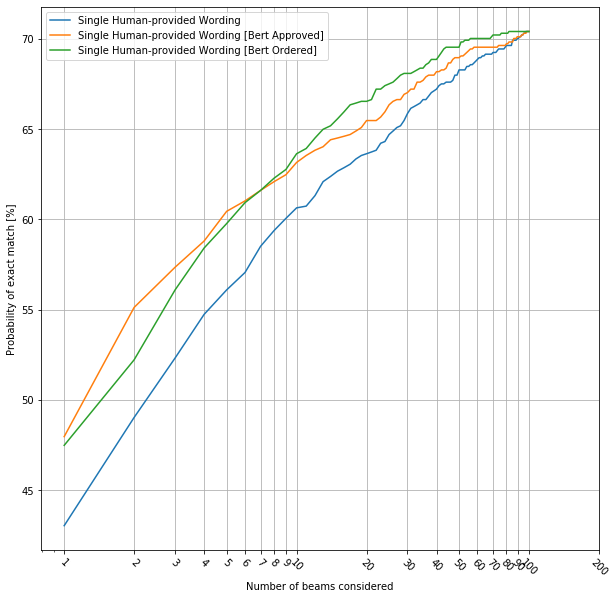

In [69]:
max_count = 100
plt.figure(figsize=(10, 10))
plt.plot(np.arange(1, 1 + max_count),
         probs_for_strat(individual_human, by_sql_humanwording_and_compwording, max_count),
         label="Single Human-provided Wording")
plt.plot(np.arange(1, 1 + max_count),
         probs_for_strat(individual_human_bert_approved, by_sql_humanwording_and_compwording, max_count),
         label="Single Human-provided Wording [Bert Approved]")
plt.plot(np.arange(1, 1 + max_count),
         probs_for_strat(individual_human_bert_ordered, by_sql_humanwording_and_compwording, max_count),
         label="Single Human-provided Wording [Bert Ordered]")
# plt.plot(np.arange(1, 1 + max_count),
#          probs_for_strat(all_human, by_sql_humanwording_and_compwording, max_count),
#          label="round robin all human paraphrases")
# for k in 1, 2:
#     plt.plot(np.arange(1, 1 + max_count),
#              probs_for_strat(lambda x: individual_human_with_computer_paraphrasing(x, k),
#                              by_sql_humanwording_and_compwording,
#                              max_count),
#              "--",
#              label="round robin one human paraphrase + %s computer paraphrases" % k)
# for k in 1, 2, 4:
#     plt.plot(np.arange(1, 1 + max_count),
#              probs_for_strat(lambda x: individual_human_with_computer_paraphrasing_by_score(x, k),
#                              by_sql_humanwording_and_compwording,
#                              max_count),
#              "--",
#              label="independently score-order interleaved one human paraphrase + %s computer paraphrases" % k)

plt.ylabel("Probability of exact match [%]")
plt.xlabel("Number of beams considered")
plt.xscale('log')
plt.legend()
ticks = list(range(1, 10)) + list(range(10, 101, 10)) + [200]
plt.xticks(ticks, labels=ticks, rotation=-45)
plt.grid()

In [78]:
track_record = []
for sql, by_human_wording in by_sql_humanwording_and_compwording.items():
    for human_wording in by_human_wording:
        beam = by_human_wording[human_wording][human_wording]
        track_record += [b['match_score']['labels'] == b['exact'] for b in beam[:10]]
np.mean(track_record)

0.8725338491295939